In [8]:
import warnings
warnings.filterwarnings("ignore")
import glob
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision.transforms as transforms
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, confusion_matrix

In [9]:
import sys
sys.path.append("../pyfiles/")
from util import image_from_output, cuda2numpy, cuda2cpu, weights_init, plot_confusion_matrix
from dataset import get_class_label, FaceDataset
from model import MinMax

# Introduction
---
The aim of this notebook is to train a classifier with the same structure as the encoder for Style-Restricted GAN. In this model, it exploits the pretrained model to restrict how the generator diversifies detailed in `05-train_Style_Restricted_GAN.ipynb`.

---

# CelebA Dataset
---
In this experiment, I'm gonna use the CelebA dataset, a face dataset that has plenty of annotations. We're therefore able to set various classes or conditions. I explained the details in `A_CelebA_dataset_usage.ipynb`.

---
### Preparation
---
First of all, navigate `root` to the root directory of the dataset and `label_root` to the directory of the label folder. `A_CelebA_dataset_usage.ipynb` also includes how the make the label folder.

---

In [10]:
root = "./../../dataset/celebA/img/"
label_root = "./../../dataset/celebA/label_folder/"
# root = "./../../research/sound_dataset/celebA/img_align_celeba_png/"
# label_root = "./../../research/sound_dataset/celebA/label_folder/"

---
As I said, the CelebA dataset has plenty of annotations, so we need to define which annotation we're gonna use.
There are 3 ways to categorize the usage of the annotations.

- ***existed***: Get the images that belong to the selected annotations.
- ***delete***: Delete the images which belong to the selected annotations.
- ***class***: These annotations are used to compose the classes, \# of classes will be $2^{\#\_classes}$

In this experiment, I used some annotations owing to simplicity and 
set the classes by the use of annotations; "male", "smiling".

---

In [11]:
# 1 5 o clock shadow
# 11 blurry
# 14 chubby
# 15 double chin
# 16 eyeglasses
# 17 goatee
# 21 male
# 23 mustache
# 25 No_Beard
# 31 sideburns
# 32 smiling
# 36 wearing hat
dataset_label = {}
dataset_label["existed"] = [25] 
dataset_label["delete"] = [1, 11, 14, 15, 16, 17, 23, 31, 36] 
dataset_label["class"] = [21, 32] 

In [12]:
label_discription = [
    "male, smiling",
    "male, not smiling",
    "female, smiling",
    "female, not smiling"
]

classes = tuple(range(2**len(dataset_label["class"])))
cl = get_class_label(len(dataset_label["class"]))
classes

(0, 1, 2, 3)

---
### Preprocessing
---
Firstly, The image in the dataset is center-cropped to be the shape (178, 178) and then resized to be the shape (128, 128). In the training process, the random horizontal flip is installed to augment the dataset. When it comes to the value of the image, it's normalized to a range of [-1, 1].


---

In [13]:
transform = {}
transform["train"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    MinMax(True)
])
    
transform["test"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    MinMax(True)
])

---
Let's have a look at some samples of the dataset.

---

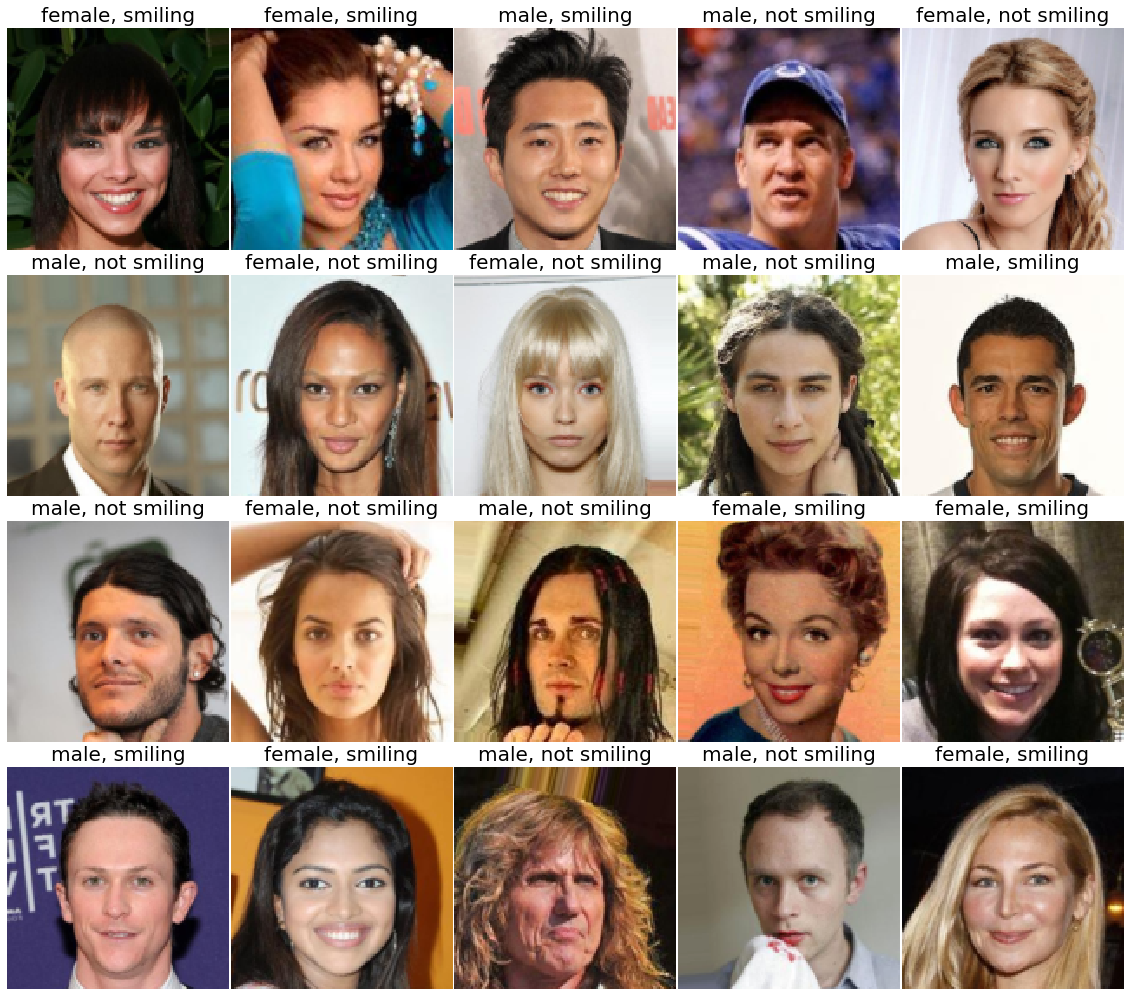

In [14]:
width = 5
length = 4
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=10000, val_num=0, test_num=100)
fig = plt.figure(figsize=(4*width, 4.5*length))
for i in range(width*length):
    ax = fig.add_subplot(length, width, i+1)
    index = np.random.randint(0,len(dataset))
    data = dataset[index]
    img = data[0]
    image = image_from_output(torch.reshape(img, (1,img.shape[0],img.shape[1],img.shape[2])))[0]
    ax.imshow(image)
    ax.set_title(label_discription[data[1]], fontsize=20)
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.03)

# Training
---
Let's train the classifier.

---
### Preparation
---
To observe the accuracy while training, firstly the fuction for test process is defined below.

---

In [15]:
def do_test(net, testloader, device="cuda", mode="eval"):
    if mode=="train":
        net.train()
    elif mode=="eval":
        net.eval()
    else:
        return None
    labels = np.array([])
    with torch.no_grad():
        for itr, data in enumerate(testloader):
            images = data[0].to(device)
            label = cuda2numpy(data[1])
            output = cuda2numpy(net(images))
            if itr==0:
                outputs = output
            else:
                outputs = np.concatenate([outputs, output], axis=0)
            labels = np.append(labels, label)
    return labels, outputs

---
At first, let's define some parameters for the architecture of the classifier.

---

In [16]:
nch_in = 3 # the number of channels for input images
nch = 64 # the number of channels for the first convolutional layer

epoch_num = 301 # the number of epochs
lr = 0.0001 # initial learning rate
save_parameter = True # do you wanna save parameters ?
test_interval = 3 # the interval among validation check
ndim = 8 # dimension of the latent code for style
ref_label = np.eye(len(classes)) # classlabel: one-hot label is employed

In [17]:
torch.cuda.set_device("cuda:4")
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

---
Then, let's call the encoder and the algorithms for training.

---

In [18]:
net = Encoder_classifier(nch_in, ndim, nch, 4, "instance", ref_label.shape[1]).to(device)
net.apply(weights_init)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

---
Then, call the training and the validation dataset.

---

In [19]:
###############################################
############ adjustable parameters ############

each_train_num = 10000
each_val_num = 1000
each_test_num = 100
train_batch = 512
val_batch = 512

###############################################
###############################################

dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=train_batch, shuffle=True)

valset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="val", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=train_batch, shuffle=False)
len(dataset), len(valset)

(40000, 4000)

---
Let's train your model. The model's accuracy is being tested every 3 epochs with the validation dataset.

---

300
test acc in 300 : 0.901
best acc is   : 0.90425 in epoch228


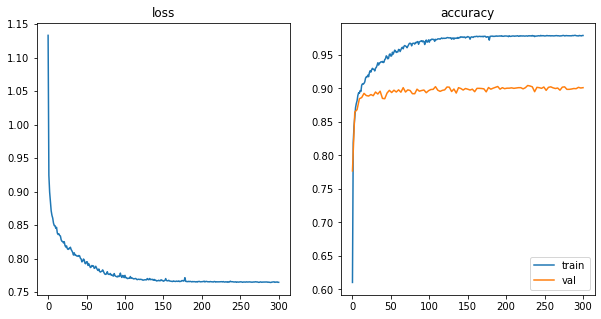

In [17]:
net.train()
losses_epoch = []
acc_epoch = []
acc_test_list = []
best_epoch = 0
best_acc = 0
for epoch in range(epoch_num):
    losses = []
    accs = []
    for itr, data in enumerate(dataloader):
        net.train()
        x = data[0].to(device)
        label = data[1].to(device)
        optimizer.zero_grad()
        y = net(x)
        loss = criterion(y, label)
        loss.backward()
        optimizer.step()
        loss = cuda2numpy(loss)
        label = cuda2numpy(label)
        y = cuda2numpy(y)
        acc = (np.argmax(y, axis=1) == label).sum().item()/len(label)
        losses.append(loss)
        accs.append(acc)
    scheduler.step()
    losses_epoch.append(np.mean(np.array(losses)))
    acc_epoch.append(np.mean(np.array(accs)))
    if epoch%test_interval==0:
        labels, outputs = do_test(net, valloader, device, "eval")
        pred_labels = np.argmax(outputs, axis=1) 
        acc_test = accuracy_score(labels, pred_labels)
        acc_test_list.append(acc_test)
        if best_acc < acc_test:
            best_acc = acc_test
            best_epoch = epoch
            
    clear_output(wait=True)
    print(epoch)
    print(f"test acc in {epoch//test_interval*test_interval} : {acc_test}")
    print(f"best acc is   : {best_acc} in epoch{best_epoch}")
    
    if save_parameter:
        if epoch%test_interval==0:
            torch.save(net.state_dict(), f"./instant_model_parameter/facial_recognizer_encoder_lr{lr}_epoch{epoch}.pth")
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,2,1)
    ax.plot(losses_epoch)
    ax.set_title("loss")
    ax = fig.add_subplot(1,2,2)
    ax.plot(acc_epoch, label="train")
    ax.plot(np.arange(epoch//test_interval+1)*test_interval, acc_test_list, label="val")
    ax.legend()
    ax.set_title('accuracy')
    plt.show()

---
You can load the well-trained model with the code below.

---

In [37]:
load_parameter = True
dir = "../data/parameters/04/"
model_path = f"{dir}facial_recognizer_encoder_lr0.0001_epoch228.pth"
if load_parameter:
    model = torch.load(model_path) 
    net.load_state_dict(model)

---
This is the test dataset. Of course, this is separated from the training and the validation dataset.

---

In [38]:
# ----- adjustable parameters ----- #
each_train_num = 10000
each_val_num = 1000
each_test_num = 100
test_batch = 512
# --------------------------------- #

testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=test_batch, shuffle=False)
len(testset)

400

---
Evaluate it many times.

---

In [39]:
# ----- adjustable parameters ----- #
test_num = 10
# --------------------------------- #

acc_list = []
cm_list = []
for i in range(test_num):
    print(i)
    labels, outputs = do_test(net, testloader, device, "eval")
    pred_labels = np.argmax(outputs, axis=1) 
    acc_test = accuracy_score(labels, pred_labels)
    acc_list.append(acc_test)
    cm = confusion_matrix(labels, pred_labels, labels=np.arange(len(classes)))
    cm_list.append(cm)
    clear_output(wait=True)
print(f"test acc is : {np.mean(acc_list)}")

test acc is : 0.8825


---
Check the detail (confusion matrix)

---

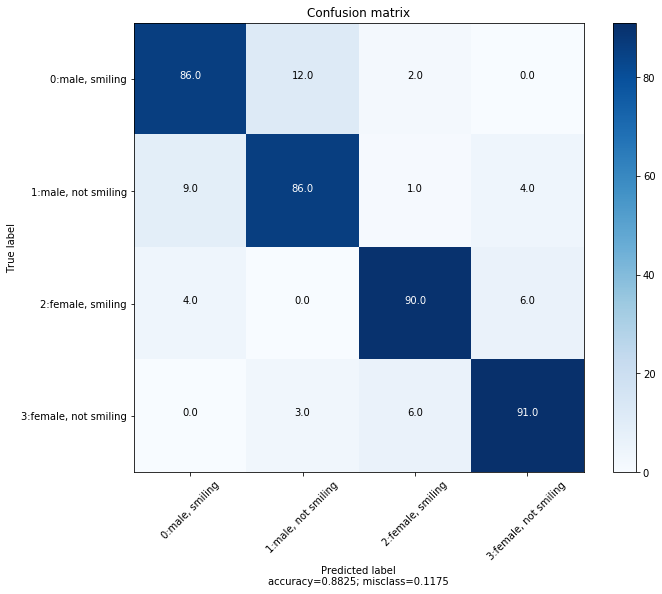

In [41]:
class_idx_lbl = label_discription.copy()
for i in range(len(label_discription)):
    class_idx_lbl[i] = f"{i}:{label_discription[i]}"
        
cm = np.mean(np.array(cm_list), axis=0)
plot_confusion_matrix(cm, class_idx_lbl, normalize=False)

## Misclassification
---
It's also essential to observe the mis-classification in order to improve your model or to find some flaws of the model.

---


the samples of 'female, smiling' which are classified as 'female, not smiling''



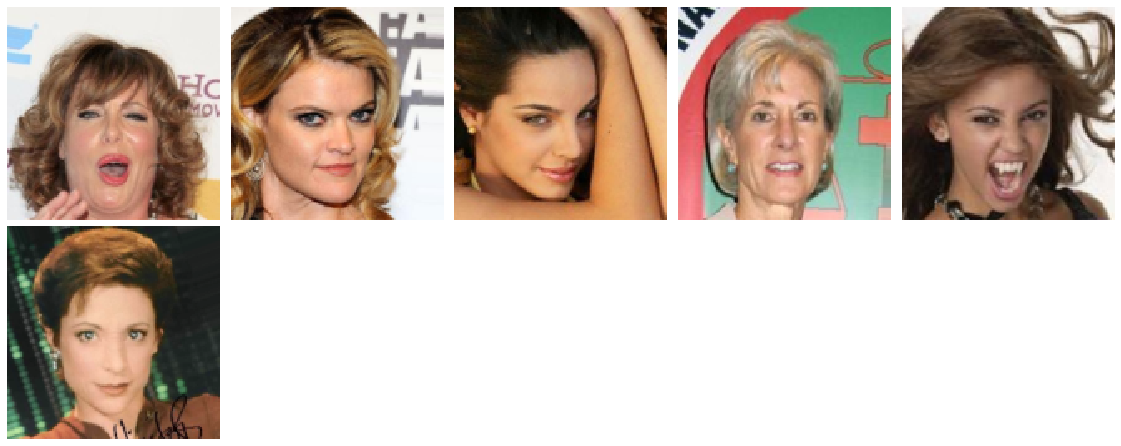

In [42]:
# ----- adjustable parameters ----- #
true_class = 2
misclassified_class = 3
width = 5
length = 4
# --------------------------------- #
print("")
print(f"the samples of '{label_discription[true_class]}' which are classified as '{label_discription[misclassified_class]}''")
print("")
fig = plt.figure(figsize=(4*width, 4*length))
miss_index_list = np.arange(len(labels))[np.array(np.array(pred_labels==misclassified_class, dtype=np.int) * np.array(labels==true_class, dtype=np.int), dtype=np.bool)]
for i in range(len(miss_index_list[:width*length])):
    ax = fig.add_subplot(length, width, i+1)
    x, label = testset[miss_index_list[i]]
    ax.imshow(image_from_output(x[np.newaxis])[0])
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.03)

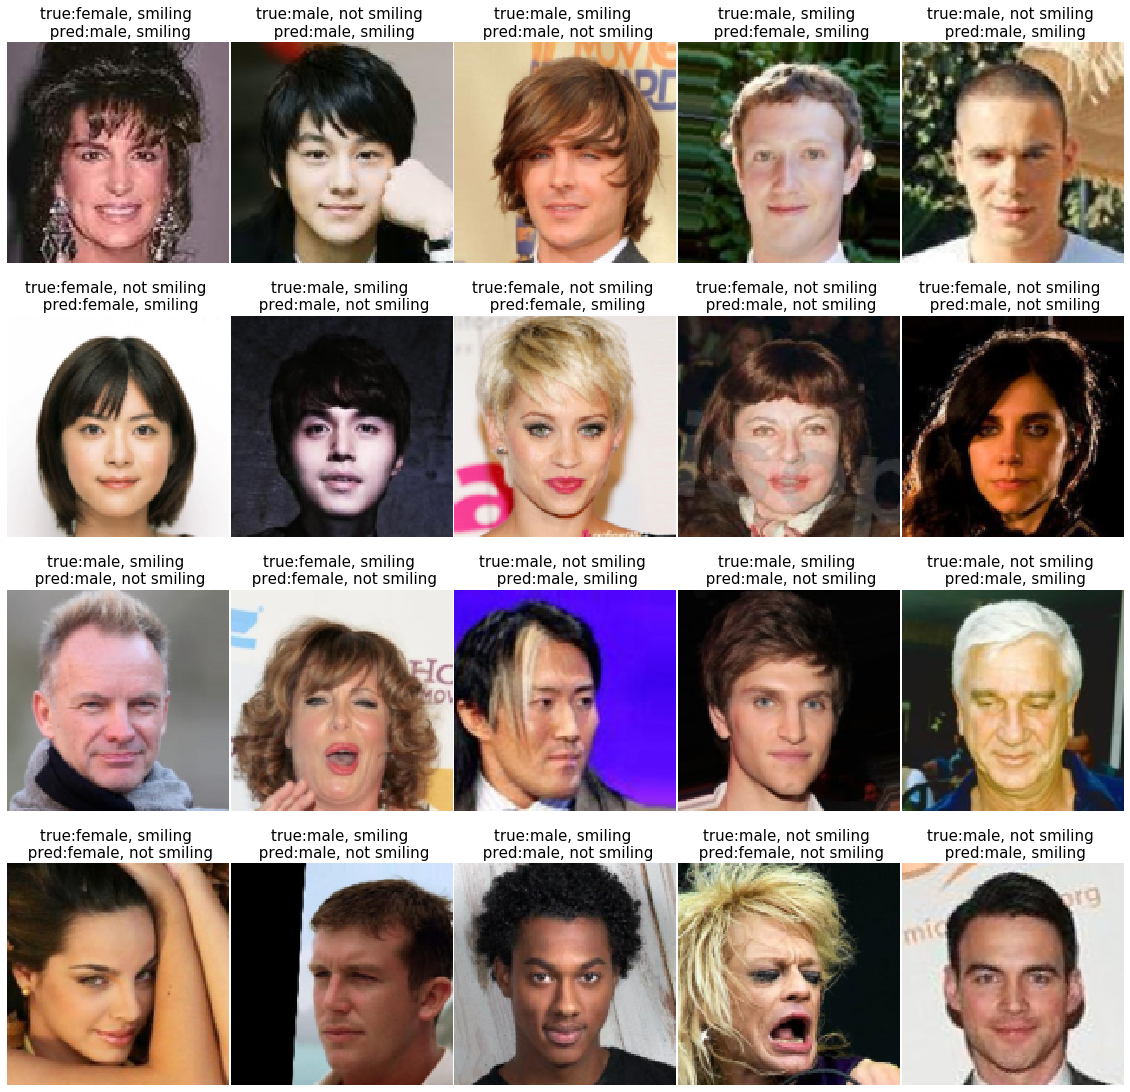

In [43]:
# ----- adjustable parameters ----- #
width = 5
length = 4
# --------------------------------- #

index_bool = pred_labels!=labels
indexes = np.random.choice(np.arange(len(labels))[index_bool], size=min(width*length,index_bool.sum()), replace=False)

fig = plt.figure(figsize=(4*width, 5*length))
for i in range(len(indexes)):
    idx = indexes[i]
    ax = fig.add_subplot(length, width, i+1)
    x, label = testset[idx]
    ax.imshow(image_from_output(x[np.newaxis])[0])
    title = f"true:{label_discription[int(labels[idx])]} \n pred:{label_discription[pred_labels[idx]]}"
    ax.set_title(title, fontsize=15)
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.03)